In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import io

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [2]:
from utils import *
from data import *
from models import *
from train import *

In [3]:
%run data.py
%run utils.py
%run models.py
%run train.py

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Import

In [5]:
data_1lead = import_afc_data()

labelmap = {x:i for i,x in enumerate(list(set([x[1] for x in data_1lead])))}

dataset_1lead = WindowDataset(data_1lead, labelmap, device=device)

  0%|          | 0/8528 [00:00<?, ?it/s]

100%|██████████| 8528/8528 [00:00<00:00, 22147.22it/s]


In [6]:
data_12lead = import_balanced_12lead_data()

# dataset_12lead = WindowDataset(data_12lead, labelmap, device=device)

In [7]:
dataset_12lead = WindowDataset(data_12lead, labelmap, device=device, trim_samples=1000)


In [8]:
pd.Series([x[1] for x in data_1lead]).value_counts()

N    5076
O    2415
A     758
~     279
Name: count, dtype: int64

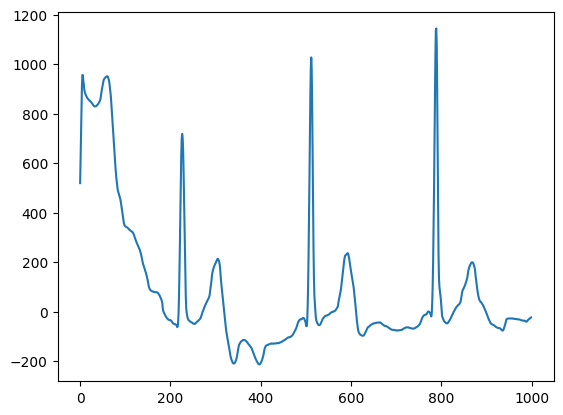

In [9]:
def plotwave(x, n=1000):
    plt.plot(x[:n])

plotwave(data_1lead[3][0])

In [10]:
value_counts = dataset_1lead.get_value_counts()
weights = [sum(value_counts)/x for x in value_counts]
weights[labelmap['~']] = weights[labelmap['N']]

# Training

In [11]:
## Train k-fold crossvalidated model on 1 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap

# history = train_kfold_model(dataset_1lead, trainparams, test=)

# plot_tt_graph(history, idx=0)
# display_results(history,trainparams=trainparams)

In [12]:
## Build model on entire 1lead dataset and save to buffer

buffer = io.BytesIO()

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs = 250

model, history = train_entire_model(dataset_1lead, trainparams)

torch.save(model.state_dict(), buffer)

Epoch:10/250 AVG Training Loss:0.02513 AVG Test Loss:0.02379 AVG Training Acc 51.99 % AVG Test Acc 53.59 %
Epoch:20/250 AVG Training Loss:0.02273 AVG Test Loss:0.02137 AVG Training Acc 60.41 % AVG Test Acc 62.96 %
Epoch:30/250 AVG Training Loss:0.02167 AVG Test Loss:0.01992 AVG Training Acc 63.22 % AVG Test Acc 66.14 %
Epoch:40/250 AVG Training Loss:0.02047 AVG Test Loss:0.01931 AVG Training Acc 64.36 % AVG Test Acc 64.79 %
Epoch:50/250 AVG Training Loss:0.02012 AVG Test Loss:0.01876 AVG Training Acc 65.62 % AVG Test Acc 67.87 %
Epoch:60/250 AVG Training Loss:0.01998 AVG Test Loss:0.01822 AVG Training Acc 65.83 % AVG Test Acc 69.59 %
Epoch:70/250 AVG Training Loss:0.01946 AVG Test Loss:0.01848 AVG Training Acc 65.56 % AVG Test Acc 69.00 %
Epoch:80/250 AVG Training Loss:0.01936 AVG Test Loss:0.01783 AVG Training Acc 66.52 % AVG Test Acc 69.65 %
Epoch:90/250 AVG Training Loss:0.01892 AVG Test Loss:0.01779 AVG Training Acc 67.33 % AVG Test Acc 69.24 %
Epoch:100/250 AVG Training Loss:0.019

In [16]:
len(dataset_12lead)/20

165.9

Fold 1
Epoch:10/100 AVG Training Loss:0.00793 AVG Test Loss:0.00513 AVG Training Acc 68.48 % AVG Test Acc 69.20 %
Epoch:20/100 AVG Training Loss:0.00710 AVG Test Loss:0.00489 AVG Training Acc 80.61 % AVG Test Acc 71.77 %
Epoch:30/100 AVG Training Loss:0.00567 AVG Test Loss:0.00501 AVG Training Acc 85.45 % AVG Test Acc 72.88 %
Epoch:40/100 AVG Training Loss:0.00554 AVG Test Loss:0.00544 AVG Training Acc 89.09 % AVG Test Acc 73.30 %
Early stopping triggered after epoch 44
Fold 2
Epoch:10/100 AVG Training Loss:0.00778 AVG Test Loss:0.00500 AVG Training Acc 73.33 % AVG Test Acc 70.19 %
Epoch:20/100 AVG Training Loss:0.00674 AVG Test Loss:0.00499 AVG Training Acc 80.61 % AVG Test Acc 70.66 %
Epoch:30/100 AVG Training Loss:0.00607 AVG Test Loss:0.00515 AVG Training Acc 86.67 % AVG Test Acc 71.30 %
Early stopping triggered after epoch 35
Fold 3
Epoch:10/100 AVG Training Loss:0.00794 AVG Test Loss:0.00501 AVG Training Acc 72.29 % AVG Test Acc 70.18 %
Epoch:20/100 AVG Training Loss:0.00655 AVG 

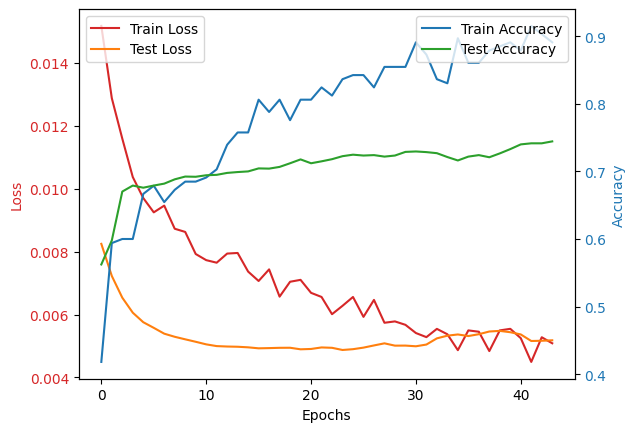

Overall results of 20 fold cross-validation with leave-19-out
Train: Average loss 0.0051945155240968, average accuracy 91.50146038700257
Test: Average loss 0.005219203905328154, average accuracy 73.05288624080524


In [13]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=20
trainparams.m=19
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, buffer, trainparams, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/200 AVG Training Loss:0.01408 AVG Test Loss:0.00904 AVG Training Acc 32.73 % AVG Test Acc 33.33 %
Epoch:20/200 AVG Training Loss:0.01345 AVG Test Loss:0.00879 AVG Training Acc 35.76 % AVG Test Acc 33.33 %


Epoch:30/200 AVG Training Loss:0.01322 AVG Test Loss:0.00871 AVG Training Acc 40.00 % AVG Test Acc 34.32 %
Epoch:40/200 AVG Training Loss:0.01319 AVG Test Loss:0.00853 AVG Training Acc 39.39 % AVG Test Acc 46.69 %
Epoch:50/200 AVG Training Loss:0.01217 AVG Test Loss:0.00808 AVG Training Acc 61.82 % AVG Test Acc 50.62 %
Epoch:60/200 AVG Training Loss:0.00977 AVG Test Loss:0.00760 AVG Training Acc 66.67 % AVG Test Acc 56.23 %
Epoch:70/200 AVG Training Loss:0.00860 AVG Test Loss:0.00767 AVG Training Acc 72.12 % AVG Test Acc 56.39 %
Epoch:80/200 AVG Training Loss:0.00699 AVG Test Loss:0.00817 AVG Training Acc 75.15 % AVG Test Acc 57.06 %
Early stopping triggered after epoch 81
Fold 2
Epoch:10/200 AVG Training Loss:0.01407 AVG Test Loss:0.00903 AVG Training Acc 36.97 % AVG Test Acc 40.66 %
Epoch:20/200 AVG Training Loss:0.01352 AVG Test Loss:0.00877 AVG Training Acc 35.76 % AVG Test Acc 33.33 %
Epoch:30/200 AVG Training Loss:0.01321 AVG Test Loss:0.00868 AVG Training Acc 36.97 % AVG Test Ac

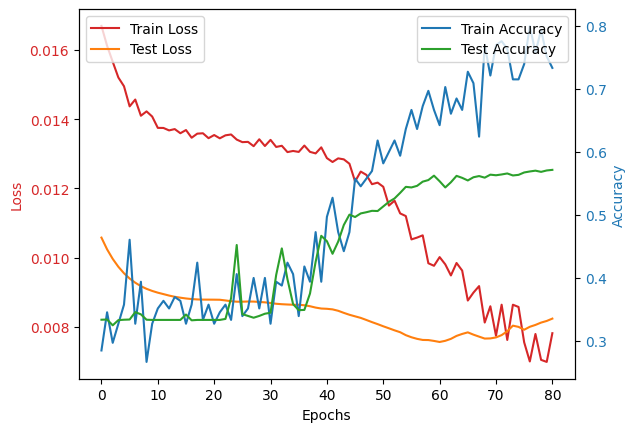

Overall results of 20 fold cross-validation with leave-19-out
Train: Average loss 0.007022752731157158, average accuracy 80.28641840087623
Test: Average loss 0.008097528854873392, average accuracy 56.717845163175504


In [14]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs=200
trainparams.k=20
trainparams.m=19
trainparams.early_stopping=20

history = train_control_12lead_model(dataset_12lead, trainparams, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)